In [1]:
# CELL 1: Imports
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import time
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# CELL 2: Configuration
CSV_PATH = r"dataset_100k_features.csv"
MODEL_FILENAME = "xgboost_readmission_model.ubj"
OPTIONAL_JSON_EXPORT = os.getenv("EXPORT_JSON_MODEL", "false").lower() == "true"
LEGACY_JSON_PATH = "xgboost_readmission_model.json"
TARGET_COL = 'label_readmission'
NULL_THRESHOLD = 0.80  # Drop columns with >80% null

print(f"📋 Configuration: {TARGET_COL} | Null threshold: {NULL_THRESHOLD*100}%")


📋 Configuration: label_readmission | Null threshold: 80.0%


In [3]:
# CELL 3: Load Raw Data
print(f"📂 Chargement de {CSV_PATH} ...")
start_time = time.time()

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"❌ Fichier introuvable : {CSV_PATH}")

df_raw = pd.read_csv(CSV_PATH)
print(f"✅ Dataset brut chargé: {df_raw.shape[0]} lignes × {df_raw.shape[1]} colonnes")
print(f"⏱️ Temps: {time.time() - start_time:.2f}s")


📂 Chargement de dataset_100k_features.csv ...
✅ Dataset brut chargé: 146808 lignes × 35 colonnes
⏱️ Temps: 0.21s


In [4]:
# CELL 4: Exploratory Data Analysis - Overview
print("🔍 === ANALYSE EXPLORATOIRE DES DONNÉES ===\n")

print(f"📊 Shape: {df_raw.shape}")
print(f"\n📋 Colonnes ({len(df_raw.columns)}):")
print(df_raw.columns.tolist())

print(f"\n🎯 Target Distribution:")
print(df_raw[TARGET_COL].value_counts())
print(f"\nBalance: {df_raw[TARGET_COL].value_counts(normalize=True).round(3)}")

print("\n👁️ Aperçu des premières lignes:")
df_raw.head()


🔍 === ANALYSE EXPLORATOIRE DES DONNÉES ===

📊 Shape: (146808, 35)

📋 Colonnes (35):
['encounter_id', 'patient_id', 'start_date', 'age', 'gender_male', 'race_white', 'race_black', 'label_readmission', 'feat_diabetes', 'feat_hypertension', 'feat_heart_failure', 'feat_respiratory', 'feat_renal', 'feat_anemia', 'feat_cholesterol', 'feat_obesity', 'feat_mental_health', 'feat_arthritis', 'feat_cancer', 'feat_stroke', 'med_insulin', 'med_metformin', 'med_aspirin', 'med_statin', 'med_beta_blocker', 'med_ace_inhibitor', 'med_diuretic', 'med_anticoagulant', 'vit_sys_bp', 'vit_dia_bp', 'vit_heart_rate', 'vit_bmi', 'vit_respiratory_rate', 'vit_cholesterol_total', 'vit_glucose']

🎯 Target Distribution:
label_readmission
0    93420
1    53388
Name: count, dtype: int64

Balance: label_readmission
0    0.636
1    0.364
Name: proportion, dtype: float64

👁️ Aperçu des premières lignes:


,encounter_id,patient_id,start_date,age,gender_male,race_white,race_black,label_readmission,feat_diabetes,feat_hypertension,...,med_ace_inhibitor,med_diuretic,med_anticoagulant,vit_sys_bp,vit_dia_bp,vit_heart_rate,vit_bmi,vit_respiratory_rate,vit_cholesterol_total,vit_glucose
0,7e5e64be-5c62-2c81-985f-dc8014db74a6,00007176-9f90-5015-4d15-42d08714ed66,1992-02-09 12:19:26,50.0,0,1,0,0,1,0,...,0,0,0,121.300000,77.8,76.600000,29.44,13.9,181.715385,79.480000
1,cf1d9df8-a005-2306-4d2a-c8d54237f6ec,0001fbc8-189b-9694-c57f-75e1314b2f66,1981-03-15 13:05:38,56.0,0,1,0,0,1,1,...,1,0,0,119.777778,78.0,79.888889,27.50,14.0,219.311111,115.111111
2,5bf3409d-c6fc-a60f-23a1-1dbbbbb1e56b,0002091c-22cb-c6bd-bffc-90ea9b536504,2007-12-20 01:25:42,82.0,1,0,1,0,1,1,...,0,1,0,118.400000,83.5,85.300000,27.80,13.7,177.875000,79.230000
3,1d71498f-8d87-93e5-f0a6-ad60884c9d07,0002091c-22cb-c6bd-bffc-90ea9b536504,2007-11-16 04:28:42,82.0,1,0,1,0,1,1,...,0,1,0,118.400000,83.5,85.300000,27.80,13.7,177.875000,79.230000
4,196c28c1-3422-1c73-16a1-8a7be3aca89d,0002091c-22cb-c6bd-bffc-90ea9b536504,2007-10-18 07:26:42,82.0,1,0,1,1,1,1,...,0,1,0,118.400000,83.5,85.300000,27.80,13.7,177.875000,79.230000


🕳️ === ANALYSE DES VALEURS MANQUANTES ===

                                      Column  Missing_Count  Missing_Percent
vit_glucose                      vit_glucose          44403            30.25
vit_cholesterol_total  vit_cholesterol_total          10576             7.20
vit_bmi                              vit_bmi            388             0.26
vit_respiratory_rate    vit_respiratory_rate            305             0.21
vit_heart_rate                vit_heart_rate            305             0.21
vit_dia_bp                        vit_dia_bp            261             0.18
vit_sys_bp                        vit_sys_bp            261             0.18


/var/folders/jq/03k2k5692ng73ksspl14rjj00000gn/T/ipykernel_68114/2134568467.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_cols, x='Missing_Percent', y='Column', palette='viridis')


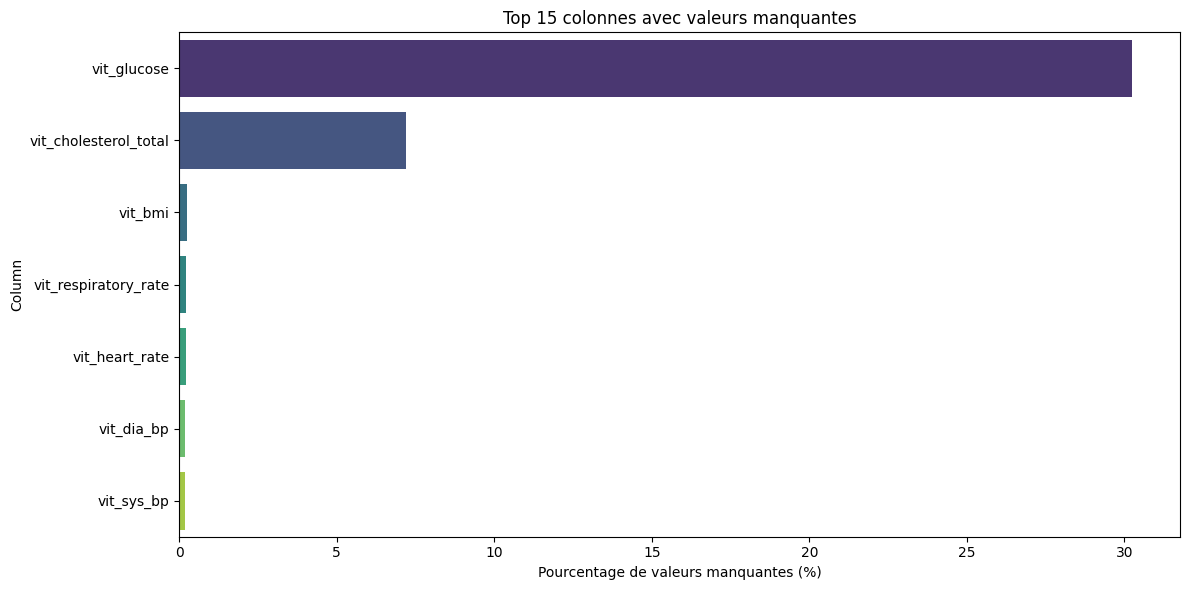


⚠️ Colonnes avec >80.0% de null:
Aucune


In [5]:
# CELL 5: EDA - Missing Values Analysis
print("🕳️ === ANALYSE DES VALEURS MANQUANTES ===\n")

# Calculate missing percentages
missing_stats = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum(),
    'Missing_Percent': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
}).sort_values('Missing_Percent', ascending=False)

print(missing_stats[missing_stats['Missing_Count'] > 0])

# Visualize missing data
plt.figure(figsize=(12, 6))
missing_cols = missing_stats[missing_stats['Missing_Count'] > 0].head(15)
sns.barplot(data=missing_cols, x='Missing_Percent', y='Column', palette='viridis')
plt.xlabel('Pourcentage de valeurs manquantes (%)')
plt.title('Top 15 colonnes avec valeurs manquantes')
plt.tight_layout()
plt.show()

print(f"\n⚠️ Colonnes avec >{NULL_THRESHOLD*100}% de null:")
high_null_cols = missing_stats[missing_stats['Missing_Percent'] > NULL_THRESHOLD*100]['Column'].tolist()
print(high_null_cols if high_null_cols else "Aucune")


In [6]:
# CELL 6: EDA - Data Types & Unique Values
print("🔢 === TYPES DE DONNÉES ===\n")
print(df_raw.dtypes.value_counts())

print("\n📊 Valeurs uniques par colonne:")
unique_counts = df_raw.nunique().sort_values()
print(unique_counts)

# Identify binary columns
binary_cols = [col for col in df_raw.columns if df_raw[col].nunique() <= 2 and col not in ['encounter_id', 'patient_id', 'start_date']]
print(f"\n✅ Colonnes binaires détectées ({len(binary_cols)}): Déjà encodées")


🔢 === TYPES DE DONNÉES ===

int64      24
float64     8
object      3
Name: count, dtype: int64

📊 Valeurs uniques par colonne:
med_beta_blocker              1
feat_arthritis                2
med_anticoagulant             2
med_diuretic                  2
med_ace_inhibitor             2
med_statin                    2
med_aspirin                   2
med_metformin                 2
med_insulin                   2
feat_stroke                   2
feat_cancer                   2
feat_mental_health            2
feat_cholesterol              2
feat_obesity                  2
feat_renal                    2
gender_male                   2
race_white                    2
feat_anemia                   2
label_readmission             2
feat_diabetes                 2
race_black                    2
feat_heart_failure            2
feat_respiratory              2
feat_hypertension             2
age                         111
vit_respiratory_rate       2878
vit_dia_bp                 3434
vit_sys_

In [7]:
# CELL 7: EDA - Statistical Summary
print("📈 === STATISTIQUES DESCRIPTIVES ===\n")

# Numeric columns only
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
print(df_raw[numeric_cols].describe().T)

# Check for outliers in vital signs
vital_cols = [col for col in df_raw.columns if col.startswith('vit_')]
print(f"\n🩺 Colonnes de signes vitaux: {vital_cols}")


📈 === STATISTIQUES DESCRIPTIVES ===

                          count        mean        std         min  \
age                    146808.0   52.772260  20.295432    0.000000   
gender_male            146808.0    0.457298   0.498175    0.000000   
race_white             146808.0    0.843789   0.363056    0.000000   
race_black             146808.0    0.071447   0.257571    0.000000   
label_readmission      146808.0    0.363659   0.481054    0.000000   
feat_diabetes          146808.0    0.506219   0.499963    0.000000   
feat_hypertension      146808.0    0.317987   0.465696    0.000000   
feat_heart_failure     146808.0    0.067387   0.250692    0.000000   
feat_respiratory       146808.0    0.035700   0.185541    0.000000   
feat_renal             146808.0    0.069335   0.254025    0.000000   
feat_anemia            146808.0    0.490157   0.499905    0.000000   
feat_cholesterol       146808.0    0.195194   0.396351    0.000000   
feat_obesity           146808.0    0.551237   0.49737

In [8]:
# CELL 8: Data Cleaning - Drop High-Null Columns
print("🧹 === NETTOYAGE DES DONNÉES ===\n")

df = df_raw.copy()

# Drop columns with >90% null
null_percentages = (df.isnull().sum() / len(df) * 100)
cols_to_drop_null = null_percentages[null_percentages > NULL_THRESHOLD * 100].index.tolist()

if cols_to_drop_null:
    print(f"❌ Suppression de {len(cols_to_drop_null)} colonnes (>{NULL_THRESHOLD*100}% null):")
    print(cols_to_drop_null)
    df = df.drop(columns=cols_to_drop_null)
else:
    print(f"✅ Aucune colonne avec >{NULL_THRESHOLD*100}% de valeurs manquantes")

print(f"\n📊 Shape après suppression: {df.shape}")


🧹 === NETTOYAGE DES DONNÉES ===

✅ Aucune colonne avec >80.0% de valeurs manquantes

📊 Shape après suppression: (146808, 35)


In [9]:
# CELL 9: Data Cleaning - Drop Identifier Columns
print("🗑️ Suppression des colonnes identifiantes...")

cols_to_drop_ids = ['encounter_id', 'patient_id', 'start_date']
cols_to_drop_ids = [c for c in cols_to_drop_ids if c in df.columns]

if cols_to_drop_ids:
    print(f"❌ Suppression: {cols_to_drop_ids}")
    df = df.drop(columns=cols_to_drop_ids)

print(f"✅ Shape finale: {df.shape}")


🗑️ Suppression des colonnes identifiantes...
❌ Suppression: ['encounter_id', 'patient_id', 'start_date']
✅ Shape finale: (146808, 32)


In [10]:
# CELL 10: Encoding Check & Feature Engineering
print("🔧 === VÉRIFICATION DE L'ENCODAGE ===\n")

# Check if categorical columns exist (non-numeric, non-binary)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != TARGET_COL]

if categorical_cols:
    print(f"⚠️ Colonnes catégorielles détectées: {categorical_cols}")
    print("Encodage requis (One-Hot ou Label Encoding)")
    
    # Example: One-hot encoding
    # df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    # print(f"✅ Encodage appliqué. Nouvelles colonnes: {df.shape[1]}")
else:
    print("✅ Toutes les colonnes sont déjà numériques/binaires")

print(f"\n📋 Colonnes finales ({len(df.columns)}):")
print(df.columns.tolist())


🔧 === VÉRIFICATION DE L'ENCODAGE ===

✅ Toutes les colonnes sont déjà numériques/binaires

📋 Colonnes finales (32):
['age', 'gender_male', 'race_white', 'race_black', 'label_readmission', 'feat_diabetes', 'feat_hypertension', 'feat_heart_failure', 'feat_respiratory', 'feat_renal', 'feat_anemia', 'feat_cholesterol', 'feat_obesity', 'feat_mental_health', 'feat_arthritis', 'feat_cancer', 'feat_stroke', 'med_insulin', 'med_metformin', 'med_aspirin', 'med_statin', 'med_beta_blocker', 'med_ace_inhibitor', 'med_diuretic', 'med_anticoagulant', 'vit_sys_bp', 'vit_dia_bp', 'vit_heart_rate', 'vit_bmi', 'vit_respiratory_rate', 'vit_cholesterol_total', 'vit_glucose']


In [11]:
# CELL 11: Missing Value Imputation Strategy
print("🔧 === TRAITEMENT DES VALEURS MANQUANTES RESTANTES ===\n")

remaining_nulls = df.isnull().sum()
cols_with_nulls = remaining_nulls[remaining_nulls > 0]

if len(cols_with_nulls) > 0:
    print(f"⚠️ Colonnes avec nulls restants:")
    print(cols_with_nulls)
    
    # Strategy for vital signs: median imputation or leave as NaN (XGBoost handles it)
    print("\n🩺 Stratégie pour vit_*: Laisser NaN (XGBoost supporte nativement)")
    print("   Alternative: df[vital_cols] = df[vital_cols].fillna(df[vital_cols].median())")
    
    # Uncomment to impute:
    # vital_cols = [col for col in df.columns if col.startswith('vit_')]
    # df[vital_cols] = df[vital_cols].fillna(df[vital_cols].median())
    # print("✅ Imputation médiane appliquée aux signes vitaux")
else:
    print("✅ Aucune valeur manquante restante")

print(f"\n📊 Dataset final prêt: {df.shape}")
df.head()


🔧 === TRAITEMENT DES VALEURS MANQUANTES RESTANTES ===

⚠️ Colonnes avec nulls restants:
vit_sys_bp                 261
vit_dia_bp                 261
vit_heart_rate             305
vit_bmi                    388
vit_respiratory_rate       305
vit_cholesterol_total    10576
vit_glucose              44403
dtype: int64

🩺 Stratégie pour vit_*: Laisser NaN (XGBoost supporte nativement)
   Alternative: df[vital_cols] = df[vital_cols].fillna(df[vital_cols].median())

📊 Dataset final prêt: (146808, 32)


,age,gender_male,race_white,race_black,label_readmission,feat_diabetes,feat_hypertension,feat_heart_failure,feat_respiratory,feat_renal,...,med_ace_inhibitor,med_diuretic,med_anticoagulant,vit_sys_bp,vit_dia_bp,vit_heart_rate,vit_bmi,vit_respiratory_rate,vit_cholesterol_total,vit_glucose
0,50.0,0,1,0,0,1,0,0,0,0,...,0,0,0,121.300000,77.8,76.600000,29.44,13.9,181.715385,79.480000
1,56.0,0,1,0,0,1,1,0,0,0,...,1,0,0,119.777778,78.0,79.888889,27.50,14.0,219.311111,115.111111
2,82.0,1,0,1,0,1,1,0,0,0,...,0,1,0,118.400000,83.5,85.300000,27.80,13.7,177.875000,79.230000
3,82.0,1,0,1,0,1,1,0,0,0,...,0,1,0,118.400000,83.5,85.300000,27.80,13.7,177.875000,79.230000
4,82.0,1,0,1,1,1,1,0,0,0,...,0,1,0,118.400000,83.5,85.300000,27.80,13.7,177.875000,79.230000


In [12]:
# CELL 11.5: Feature Selection - Remove Constants
print("🔧 === SÉLECTION DES FEATURES ===\n")

# Remove constant columns (0 variance)
constant_cols = [col for col in df.columns 
                if df[col].nunique() <= 1 and col != TARGET_COL]
if constant_cols:
    print(f"❌ Constantes supprimées: {constant_cols}")
    df = df.drop(columns=constant_cols)

# Remove near-constant (<1% positive)
low_var_cols = [col for col in df.columns 
               if (df[col].sum() / len(df) < 0.01) and col != TARGET_COL]
print(f"ℹ️ Faible variance (<1%): {low_var_cols}")

print(f"✅ Features finales: {df.shape[1]-1}")


🔧 === SÉLECTION DES FEATURES ===

❌ Constantes supprimées: ['med_beta_blocker']
ℹ️ Faible variance (<1%): []
✅ Features finales: 30


In [13]:
# CELL 12: Train/Test Split
print("✂️ === SÉPARATION TRAIN/TEST ===\n")

if TARGET_COL not in df.columns:
    raise ValueError(f"❌ Erreur : La colonne '{TARGET_COL}' est absente !")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print(f"📊 Features: {X.shape[1]}, Samples: {X.shape[0]}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"📊 Train distribution:\n{y_train.value_counts(normalize=True).round(3)}")


✂️ === SÉPARATION TRAIN/TEST ===

📊 Features: 30, Samples: 146808
✅ Train: 117446 | Test: 29362
📊 Train distribution:
label_readmission
0    0.636
1    0.364
Name: proportion, dtype: float64


In [15]:
# CELL 13: Device Detection & Model Configuration
def detect_device() -> str:
    if torch.cuda.is_available():
        print("🟢 CUDA détecté : utilisation du GPU NVIDIA.")
        return "cuda"
    print("ℹ️ CPU uniquement (pas de support CUDA/MPS pour XGBoost).")
    return "cpu"

device = detect_device()
print(f"🚀 Initialisation de XGBoost sur {device.upper()}...")

model = xgb.XGBClassifier(
    device=device,
    tree_method="hist",
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=50,
    missing=float('nan'),  # Gère les NaN automatiquement
    reg_alpha=1.0,        # L1 regularization (default: 0)
    reg_lambda=3.0,       # L2 regularization (default: 1)
    gamma=1.0,            # Minimum loss reduction for split (default: 0)
    min_child_weight=5   # Minimum sum of instance weight in child (default: 1)
           # Reduce from 6 to 4
)

print("✅ Modèle configuré!")


ℹ️ CPU uniquement (pas de support CUDA/MPS pour XGBoost).
🚀 Initialisation de XGBoost sur CPU...
✅ Modèle configuré!


In [16]:
# CELL 13: Training WITH Train/Test Tracking (FIXED)
print("🔥 === ENTRAÎNEMENT Train/Test tracking ===\n")
start_train = time.time()

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Train first, Test second
    verbose=100
)

print(f"✅ Terminé en {time.time() - start_time:.2f}s")
print(f"🏆 Best iteration: {model.best_iteration}")


🔥 === ENTRAÎNEMENT Train/Test tracking ===

[0]	validation_0-auc:0.81154	validation_1-auc:0.81443
[100]	validation_0-auc:0.83934	validation_1-auc:0.83969
[200]	validation_0-auc:0.85174	validation_1-auc:0.84991
[300]	validation_0-auc:0.86368	validation_1-auc:0.86038
[400]	validation_0-auc:0.87312	validation_1-auc:0.86862
[499]	validation_0-auc:0.87936	validation_1-auc:0.87357
✅ Terminé en 47.33s
🏆 Best iteration: 499


In [17]:
# CELL 14.5: Extract Training History (StackOverflow #1 method)
import matplotlib.pyplot as plt
import numpy as np

# Get evaluation results directly from XGBoost
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

print(f"📊 {epochs} iterations tracked")
print(f"🏆 Best iteration: {model.best_iteration}")
print(f"📈 Peak AUC: {max(results['validation_0']['auc']):.4f}")


📊 500 iterations tracked
🏆 Best iteration: 499
📈 Peak AUC: 0.8794


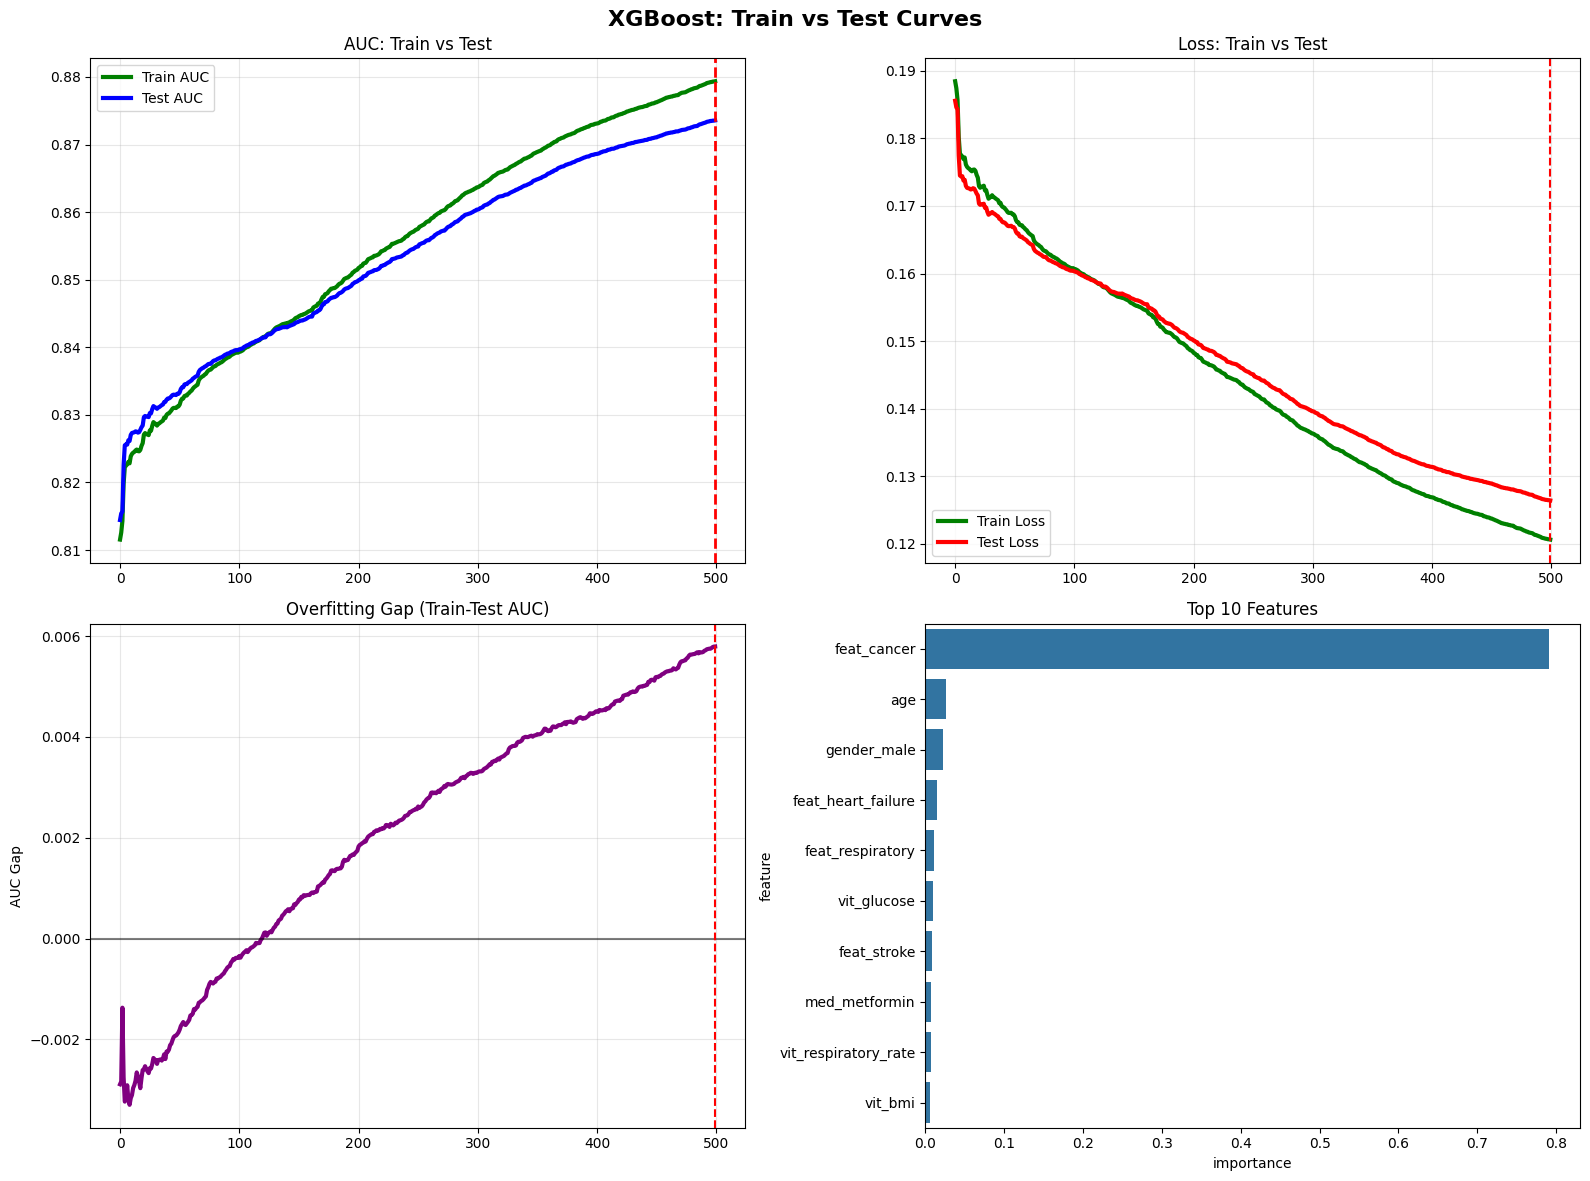

Train AUC: 0.8794
Test AUC:  0.8736
Max Gap:   0.0058


In [ ]:
# CELL 15: Train vs Test Dashboard (FINAL FIXED VERSION)
results = model.evals_result()

# Auto-detect keys
train_key = 'validation_0'  # Train set
test_key = 'validation_1'   # Test set

epochs = len(results[test_key]['auc'])
x_axis = range(0, epochs)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('XGBoost: Train vs Test Curves', fontsize=16, fontweight='bold')

# 1. AUC Curves
axes[0,0].plot(x_axis, results[train_key]['auc'], 'g-', linewidth=3, label='Train AUC')
axes[0,0].plot(x_axis, results[test_key]['auc'], 'b-', linewidth=3, label='Test AUC')  
axes[0,0].axvline(model.best_iteration, color='red', linestyle='--', linewidth=2)
axes[0,0].set_title('AUC: Train vs Test')
axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

# 2. Loss Curves
train_loss = 1 - np.array(results[train_key]['auc'])
test_loss = 1 - np.array(results[test_key]['auc'])
axes[0,1].plot(x_axis, train_loss, 'g-', linewidth=3, label='Train Loss')
axes[0,1].plot(x_axis, test_loss, 'r-', linewidth=3, label='Test Loss')
axes[0,1].axvline(model.best_iteration, color='red', linestyle='--')
axes[0,1].set_title('Loss: Train vs Test')
axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)

# 3. Overfitting Gap
gap = np.array(results[train_key]['auc']) - np.array(results[test_key]['auc'])
axes[1,0].plot(x_axis, gap, 'purple', linewidth=3)
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].axvline(model.best_iteration, color='red', linestyle='--')
axes[1,0].set_title('Overfitting Gap (Train-Test AUC)')
axes[1,0].set_ylabel('AUC Gap'); axes[1,0].grid(True, alpha=0.3)

# 4. Feature Importance
feature_imp = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False).head(10)
sns.barplot(data=feature_imp, y='feature', x='importance', ax=axes[1,1])
axes[1,1].set_title('Top 10 Features')

plt.tight_layout()
plt.show()

print(f"Train AUC: {results[train_key]['auc'][-1]:.4f}")
print(f"Test AUC:  {results[test_key]['auc'][-1]:.4f}")
print(f"Max Gap:   {max(gap):.4f}")


In [19]:
# CELL 15: Generate Predictions
print("🔮 === GÉNÉRATION DES PRÉDICTIONS ===\n")

# Binary predictions (0 or 1)
y_pred = model.predict(X_test)

# Probability predictions for ROC curve
y_prob = model.predict_proba(X_test)[:, 1]

print(f"✅ Predictions generated: {len(y_pred)} samples")
print(f"📊 Prediction distribution:\n{pd.Series(y_pred).value_counts()}")

# Calculate metrics
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\n🎯 Test Accuracy: {accuracy:.4f}")
print(f"📈 Test ROC-AUC: {roc_auc:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Readmission', 'Readmission']))


🔮 === GÉNÉRATION DES PRÉDICTIONS ===

✅ Predictions generated: 29362 samples
📊 Prediction distribution:
0    17189
1    12173
Name: count, dtype: int64

🎯 Test Accuracy: 0.7728
📈 Test ROC-AUC: 0.8736

📋 Classification Report:
                precision    recall  f1-score   support

No Readmission       0.85      0.78      0.81     18684
   Readmission       0.66      0.76      0.71     10678

      accuracy                           0.77     29362
     macro avg       0.76      0.77      0.76     29362
  weighted avg       0.78      0.77      0.78     29362



In [20]:
# CELL 16: Save Model
booster = model.get_booster()
booster.save_model(MODEL_FILENAME)
print(f"💾 Modèle sauvegardé: {MODEL_FILENAME}")

if OPTIONAL_JSON_EXPORT:
    booster.save_model(LEGACY_JSON_PATH)
    print(f"📁 JSON export: {LEGACY_JSON_PATH}")

print("🎉 Pipeline complet terminé!")


💾 Modèle sauvegardé: xgboost_readmission_model.ubj
🎉 Pipeline complet terminé!
